# Fresnel Wavefront
The `dLux` module offers fully fledged Fresnel optics capabilities based on those in `poppy`. This example shows of how to use the related capabilities.

In [1]:
from poppy import FresnelWavefront
from poppy import CircularAperture as PCircularAperture
from matplotlib import pyplot
from astropy.units import meter
from astropy import units as u
from poppy import accel_math

The first thing to notice is that in `dLux` the `Wavefront` is essentially split over two classes. The reason for this is that the autodiff package we use, `equinox` works by differentiating with respect to class attributes. While we could mix autodiff implementations and use `jax.grad` to take derivatives with respect to function arguments a uniform interface was considered better. 

As a result a `GaussianPropagator` is instantiated whenever we want to take a derivative with respect to a `distance` which is stored as an attribute of the propagator. This means that one `Wavefront` may pass through many propagators. 

A general principle of `dLux` is to abstract mathematically as well as physically, so that the development of physically informed neural network models is easy. The way that this works is the `GaussianPropagator` essentially acts as a differentiable network layer. 

Let's start by using poppy to Fresnel propagate a wavefront through a circular aperture. The parameters I use here come from [this](https://github.com/spacetelescope/poppy/blob/develop/notebooks/Fresnel_Propagation_Demo.ipynb) `poppy` example notebook.

In [2]:
p_wavefront = FresnelWavefront(0.5 * meter, wavelength=2200e-9, npix=256, 
                               oversample=4)

p_wavefront *= PCircularAperture(radius=0.5) 

# These two seem to match. Note there is no normalisation or shift. 
# p_wavefront._fft() 
# field = np.fft.ifft2(p_wavefront.wavefront)

Now let's replicate that using `dLux` and it's propagators. Now internally `dLux` nests `PyTree`s and this is something that I am really looking to remove in future versions. But for now we wrap the wavefront in a dictionary to pass it between layers. 

Another feature(?) of `dLux` at this level is that a lot less is hidden. At present there is another legacy feature the `CreateWavefront` `Layer` that doubles as a costructor for the `Wavefront`. This is also likely to change in future versions as `Source` and `Scene` classes are created. 

This means that the only parameters required to create the wavefront are `offset` and `wavelength`. The offset is the tilt of the wavefront with respect to the plane of (in this case) the aperture, and has angular units. 

A major difference between `dLux` and `poppy` is that `dLux` doesn't care about units. Everything is in SI units anything else and the code will return incorrect results. This means that all angles are in radians and all distances are in meters with very few exceptions. 

The code is documented with the units so run `help(dLux.Class.method)` to see the units of the parameters. For example, `width : float, meters`, specifies first the type and then the units. 

In [3]:
import dLux
from fresnel import GaussianPropagator, GaussianWavefront
from matplotlib import pyplot
from jax.config import config
from jax import numpy as np

In [4]:
config.update("jax_debug_nans", True)
config.update("jax_enable_x64", True)

In [5]:
npix = 256 * 4
radius = 0.5 * 4
offset = [0., 0.]
wavelength = 2200e-09
distance = 0.5

There is a bug in the pixel position centring that needs to be fixed. 

In [6]:
field = p_wavefront.wavefront

In [7]:
wavefront = GaussianWavefront(offset, wavelength, radius)\
    .update_phasor(np.abs(field), np.angle(field))\
    .set_pixel_scale(2 * radius / npix)\
    .position_after(-5000.)

In [8]:
field = wavefront.get_complex_form()

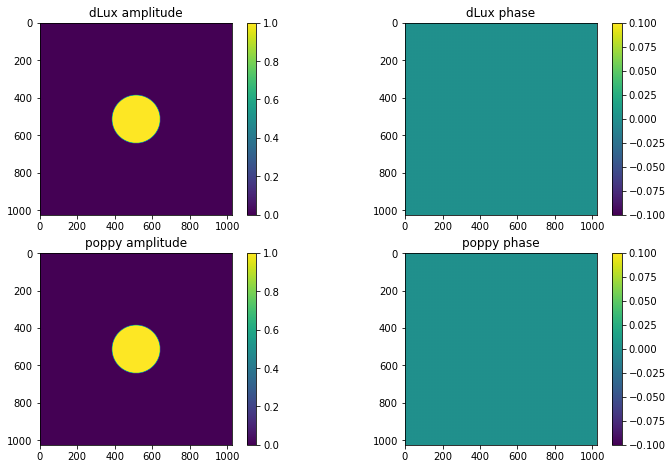

In [9]:
pyplot.figure(figsize=(12, 12))
pyplot.subplot(3, 2, 1)
pyplot.title("dLux amplitude")
pyplot.imshow(np.abs(field))
pyplot.colorbar()

pyplot.subplot(3, 2, 2)
pyplot.title("dLux phase")
pyplot.imshow(np.angle(field))
pyplot.colorbar()

pyplot.subplot(3, 2, 3)
pyplot.title("poppy amplitude")
pyplot.imshow(np.abs(p_wavefront.wavefront))
pyplot.colorbar()

pyplot.subplot(3, 2, 4)
pyplot.title("poppy phase")
pyplot.imshow(np.angle(p_wavefront.wavefront))
pyplot.colorbar()

In [10]:
propagator = GaussianPropagator(5000.)

In [11]:
out = propagator._plane_to_plane(wavefront, propagator.distance)

In [12]:
field = wavefront.get_complex_form()

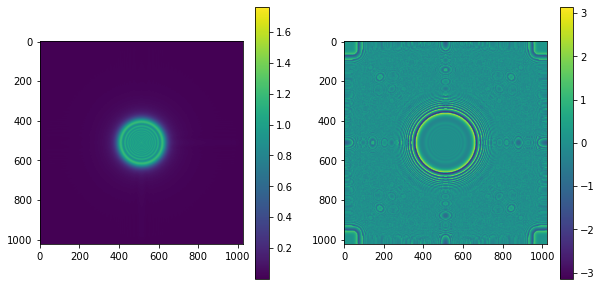

In [13]:
pyplot.figure(figsize=(10, 5))
pyplot.subplot(1, 2, 1)
pyplot.imshow(out.amplitude)
pyplot.colorbar()
pyplot.subplot(1, 2, 2)
pyplot.imshow(-out.phase)
pyplot.colorbar()

In [14]:
p_wavefront.propagate_fresnel(-5000 * meter)
out = p_wavefront.wavefront

The pixel scales differ by a factor of oversample

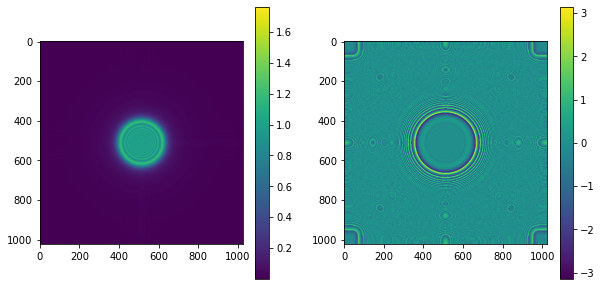

In [15]:
pyplot.figure(figsize=(10, 5))
pyplot.subplot(1, 2, 1)
pyplot.imshow(np.abs(out))
pyplot.colorbar()
pyplot.subplot(1, 2, 2)
pyplot.imshow(np.angle(out))
pyplot.colorbar()